In [1]:
!pip install tensorflow

In [2]:
!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
import xgboost as xgb
# Import KerasRegressor directly from tensorflow
from tensorflow import keras # Import keras directly
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor # Assuming TensorFlow 2.0 or later # This is the old import and is likely outdated.
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential # Import Sequential from tensorflow.keras.models
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN # Import layers from tensorflow.keras.layers
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv(
    "/content/drive/MyDrive/ML & Deep Learning/Airquality/gams_preprocessed_hourly.csv",
    parse_dates=["ts"],
    index_col="ts",
)

In [5]:
data.head()

,co2,humidity,pm10,pm25,temperature,voc,Month,Week,Day,Day_of_week,...,pm10_window,pm25_window,temperature_window,voc_window,Month_sin,Month_cos,Hour_sin,Hour_cos,Day_sin,Day_cos
ts,,,,,,,,,,,,,,,,,,,,,
2016-11-22 00:00:00,0.125142,0.681239,0.022233,0.033495,0.592737,0.000287,11,47,22,1,...,0.026882,0.041626,0.624210,0.000309,-0.5,0.866025,0.000000,1.000000,-0.968077,-0.250653
2016-11-22 01:00:00,0.159592,0.659048,0.006791,0.007556,0.613171,0.000258,11,47,22,1,...,0.028853,0.044576,0.607663,0.000319,-0.5,0.866025,0.269797,0.962917,-0.968077,-0.250653
2016-11-22 02:00:00,0.316681,0.633366,0.008445,0.009361,0.645052,0.000405,11,47,22,1,...,0.023795,0.036160,0.604318,0.000239,-0.5,0.866025,0.519584,0.854419,-0.968077,-0.250653
2016-11-22 03:00:00,0.443831,0.611913,0.018425,0.024901,0.666608,0.000563,11,47,22,1,...,0.012489,0.016804,0.616987,0.000317,-0.5,0.866025,0.730836,0.682553,-0.968077,-0.250653
2016-11-22 04:00:00,0.532989,0.624371,0.025304,0.033161,0.695313,0.011083,11,47,22,1,...,0.011220,0.013939,0.641610,0.000409,-0.5,0.866025,0.887885,0.460065,-0.968077,-0.250653


# Split into train, test and validation
We will train the model on a certain portion of the data and leave another part out to evaluate the model.

Because these are time series, I will split based on time. We leave the most recent data as test set.

In [6]:
# Verify the minimum and maximum dates in the dataset
min_date, max_date = data.index.min(), data.index.max()
print(f"Date range in data: {min_date} to {max_date}")

Date range in data: 2016-11-22 00:00:00 to 2017-03-28 09:00:00


In [7]:
# Define split dates
train_end_date = "2017-01-01"  # End date for the train set
val_end_date = "2017-03-01"    # End date for the validation set

In [8]:
# Calculate split indices based on 80%, 10%, and 10% proportions
train_size = int(len(data) * 0.8)
validation_size = int(len(data) * 0.1)

In [9]:
# Split the data chronologically
X_train = data.iloc[:train_size]                                      # First 80% for training
X_validation = data.iloc[train_size:train_size + validation_size]     # Next 10% for validation
X_test = data.iloc[train_size + validation_size:]                     # Remaining 10% for test

In [10]:
# Print the shapes to confirm
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_validation.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2332, 48)
Validation set shape: (291, 48)
Test set shape: (292, 48)


In [11]:
# Define target variable for each set
y_train = X_train["co2"].copy()
y_validation = X_validation["co2"].copy()
y_test = X_test["co2"].copy()

# Remove the target column from the predictors in each set
X_train = X_train.drop("co2", axis=1)
X_validation = X_validation.drop("co2", axis=1)
X_test = X_test.drop("co2", axis=1)

# Check the shapes to confirm
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape, "| y_validation shape:", y_validation.shape)
print("X_test shape:", X_test.shape, "| y_test shape:", y_test.shape)

X_train shape: (2332, 47) | y_train shape: (2332,)
X_validation shape: (291, 47) | y_validation shape: (291,)
X_test shape: (292, 47) | y_test shape: (292,)


In [22]:
p = ['co2', 'humidity', 'pm10', 'pm25', 'temperature', 'voc']

def return_train_data(data, feature):
    # Calculate indices for 80-10-10 split
    train_size = int(len(data) * 0.8)
    validation_size = int(len(data) * 0.1)

    # Split the data chronologically
    X_train = data.iloc[:train_size]
    X_validation = data.iloc[train_size:train_size + validation_size]
    X_test = data.iloc[train_size + validation_size:]

    # Define target variable for each set
    y_train = X_train[feature].copy()
    y_validation = X_validation[feature].copy()
    y_test = X_test[feature].copy()

    # Remove the target column from predictors in each set
    X_train = X_train.drop(feature, axis=1)
    X_validation = X_validation.drop(feature, axis=1)
    X_test = X_test.drop(feature, axis=1)

    return X_train, y_train, X_validation, y_validation, X_test, y_test, feature

**LION optimizer for LSTM**

In [25]:
pip install scikeras

In [27]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 470ms/step - loss: 0.1464
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - loss: 0.0394
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - loss: 0.0298
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - loss: 0.0405
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step - loss: 0.0181
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - loss: 0.0186
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step - loss: 0.0183
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.0094
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - loss: 0.0131
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - loss: 0.0087
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - loss: 0.0083
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step - loss: 0.0085
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 676ms/step - loss: 0.0062
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - loss: 0.0065
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - loss: 0.0060
Epoc

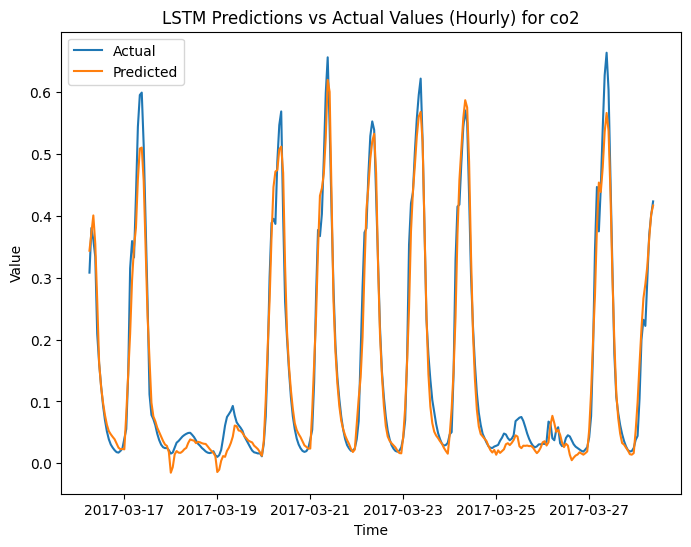

LSTM Training MSE: 0.000652
LSTM Training MAPE: 0.213590%
LSTM Validation MSE: 0.000870
LSTM Validation MAPE: 0.477589%
LSTM Testing MSE: 0.000936
LSTM Testing MAPE: 0.265764%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - loss: 0.3174
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - loss: 0.1852
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - loss: 0.0770
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 677ms/step - loss: 0.0606
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step - loss: 0.0356
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - loss: 0.0370
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step - loss: 0.0159
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - loss: 0.0272
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - loss: 0.0077
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - loss: 0.0171
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step - loss: 0.0076
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - loss: 0.0102
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - loss: 0.0070
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - loss: 0.0069
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - loss: 0.0062
Epoc

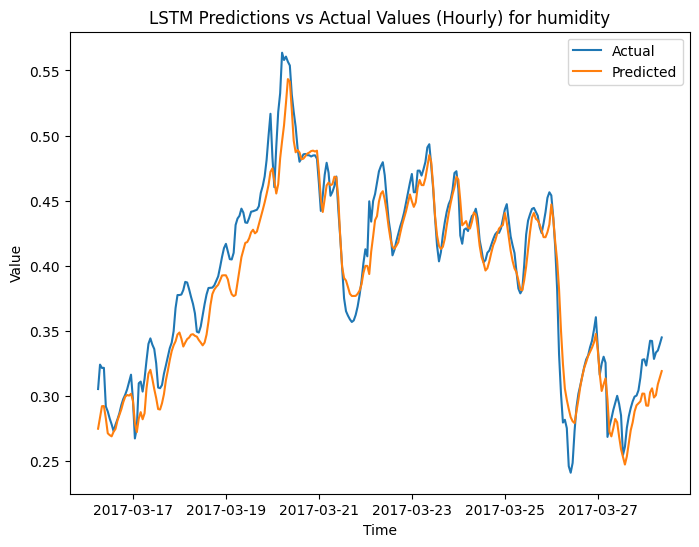

LSTM Training MSE: 0.000202
LSTM Training MAPE: 0.043783%
LSTM Validation MSE: 0.001089
LSTM Validation MAPE: 0.081712%
LSTM Testing MSE: 0.000402
LSTM Testing MAPE: 0.040744%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step - loss: 0.1489
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step - loss: 0.0939
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 704ms/step - loss: 0.0248
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - loss: 0.0687
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - loss: 0.0167
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 0.0285
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - loss: 0.0140
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - loss: 0.0140
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step - loss: 0.0105
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - loss: 0.0079
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 0.0073
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - loss: 0.0043
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 0.0049
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - loss: 0.0023
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step - loss: 0.0035
Epoc

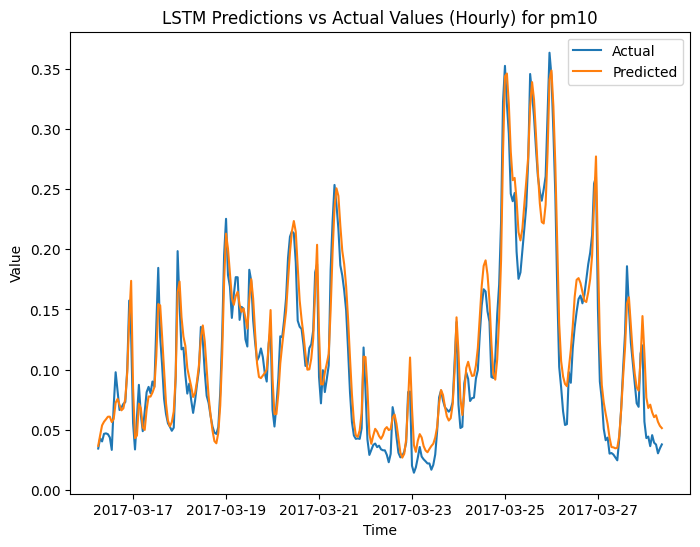

LSTM Training MSE: 0.000280
LSTM Training MAPE: 0.163414%
LSTM Validation MSE: 0.000475
LSTM Validation MAPE: 0.192537%
LSTM Testing MSE: 0.000359
LSTM Testing MAPE: 0.211178%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step - loss: 0.1694
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - loss: 0.0735
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - loss: 0.0348
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - loss: 0.0537
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - loss: 0.0269
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - loss: 0.0220
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 461ms/step - loss: 0.0221
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 0.0112
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step - loss: 0.0149
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step - loss: 0.0081
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - loss: 0.0090
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - loss: 0.0071
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - loss: 0.0052
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - loss: 0.0058
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - loss: 0.0041
Epoc

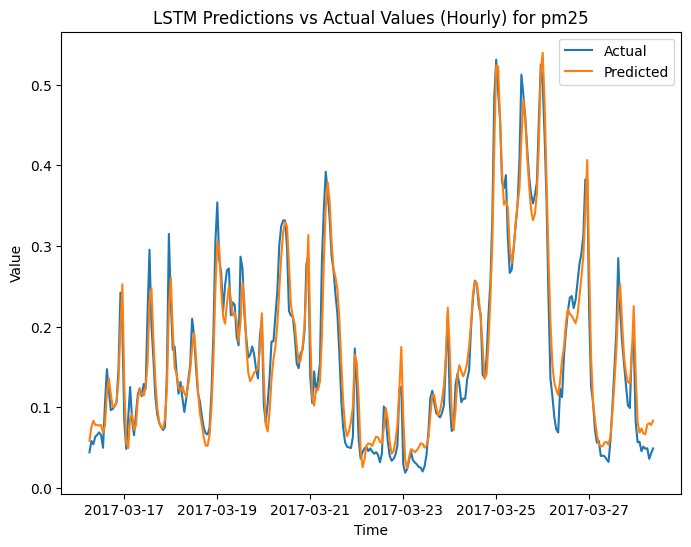

LSTM Training MSE: 0.000666
LSTM Training MAPE: 0.192861%
LSTM Validation MSE: 0.000611
LSTM Validation MAPE: 0.134498%
LSTM Testing MSE: 0.000791
LSTM Testing MAPE: 0.208005%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - loss: 0.2225
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - loss: 0.0760
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - loss: 0.0756
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - loss: 0.0508
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - loss: 0.0261
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - loss: 0.0328
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - loss: 0.0198
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - loss: 0.0191
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 0.0160
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - loss: 0.0122
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - loss: 0.0129
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step - loss: 0.0097
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - loss: 0.0097
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step - loss: 0.0098
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.0080
Epoc

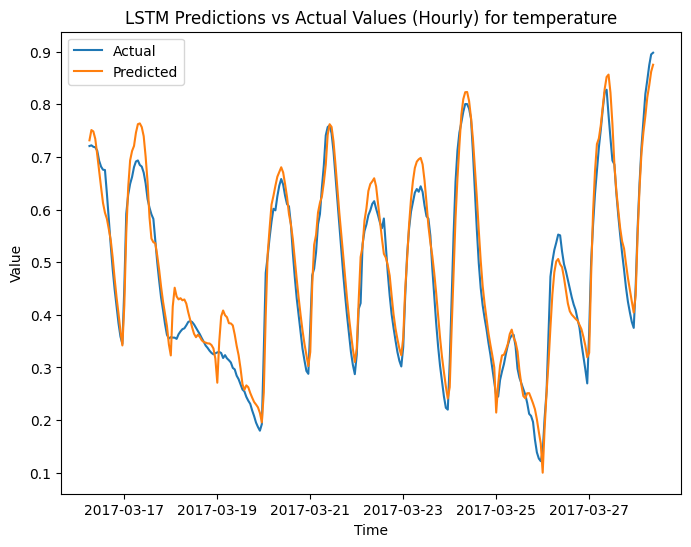

LSTM Training MSE: 0.001100
LSTM Training MAPE: 0.058067%
LSTM Validation MSE: 0.001528
LSTM Validation MAPE: 0.054999%
LSTM Testing MSE: 0.001468
LSTM Testing MAPE: 0.079687%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step - loss: 0.1647
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - loss: 0.1416
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - loss: 0.0223
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - loss: 0.0844
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 682ms/step - loss: 0.0117
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step - loss: 0.0427
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 627ms/step - loss: 0.0072
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - loss: 0.0217
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 461ms/step - loss: 0.0045
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - loss: 0.0119
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.0030
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.0065
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 633ms/step - loss: 0.0023
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step - loss: 0.0037
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - loss: 0.0021
Epoc

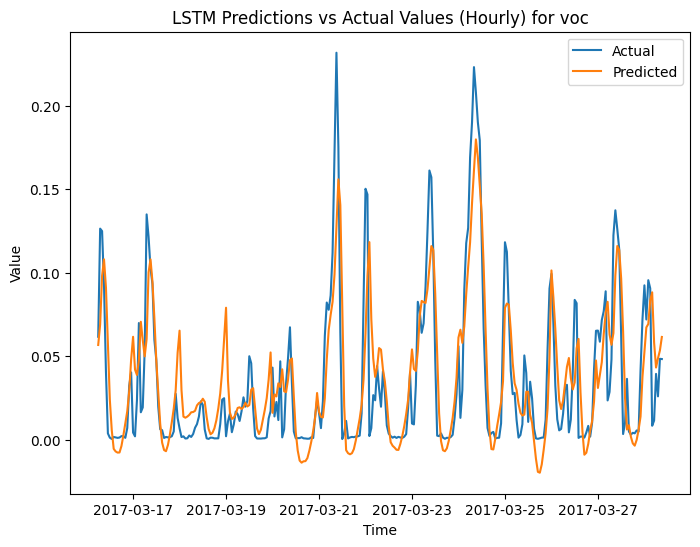

LSTM Training MSE: 0.000382
LSTM Training MAPE: 2280955867.724886%
LSTM Validation MSE: 0.000779
LSTM Validation MAPE: 6.831479%
LSTM Testing MSE: 0.000740
LSTM Testing MAPE: 4.415469%
Results written to results.json


In [31]:
def lstm_regression(X_train, y_train, X_validation, y_validation, X_test, y_test, feature):
    # Reshape training, validation, and testing data to be 3D for LSTM
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_validation = X_validation.values.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Define model architecture for LSTM
    model = Sequential()
    model.add(LSTM(1024, activation='relu', input_shape=(1, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=1024, verbose=1)

    # Make predictions on train, validation, and test data
    y_train_pred = model.predict(X_train).flatten()
    y_validation_pred = model.predict(X_validation).flatten()
    y_test_pred = model.predict(X_test).flatten()

    # Calculate MSE and MAPE for each set
    mse_train = mean_squared_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

    mse_validation = mean_squared_error(y_validation, y_validation_pred)
    mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

    # Create directory for plots if it doesn't exist
    os.makedirs("./Plots", exist_ok=True)

    # Plot predictions vs actual values on hourly timeline for the test set
    fig = plt.figure(figsize=(8, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_test_pred, label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'LSTM Predictions vs Actual Values (Hourly) for {feature}')
    plt.rcParams['figure.dpi'] = 100
    fig.savefig(f"./Plots/{feature}_Lstm.pdf", dpi=100, bbox_inches='tight')
    plt.show()

    # Print results
    print(f"LSTM Training MSE: {mse_train:.6f}")
    print(f"LSTM Training MAPE: {mape_train:.6f}%")
    print(f"LSTM Validation MSE: {mse_validation:.6f}")
    print(f"LSTM Validation MAPE: {mape_validation:.6f}%")
    print(f"LSTM Testing MSE: {mse_test:.6f}")
    print(f"LSTM Testing MAPE: {mape_test:.6f}%")

    # Return metrics for all splits
    return {
        'mse_train': mse_train,
        'mape_train': mape_train,
        'mse_validation': mse_validation,
        'mape_validation': mape_validation,
        'mse_test': mse_test,
        'mape_test': mape_test
    }

import pandas as pd
import json
import os

# Define regression models to evaluate
regression_models = [
    "LSTM"
]

# Create an empty dictionary to hold results
results_dict = {model: {} for model in regression_models}

# Loop over all features
for val in p:
    try:
        # Get training, validation, and testing data for the target feature
        data_values = return_train_data(data, val)
        X_train, y_train, X_validation, y_validation, X_test, y_test, feature_name = data_values

        # Evaluate each regression model on the selected feature
        # LSTM
        metrics = lstm_regression(X_train, y_train, X_validation, y_validation, X_test, y_test, feature_name)
        results_dict["LSTM"][feature_name] = metrics

    except Exception as e:
        print(f"Error with feature {val}: {e}")

# Write results dictionary to JSON file
with open('results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)

print("Results written to results.json")